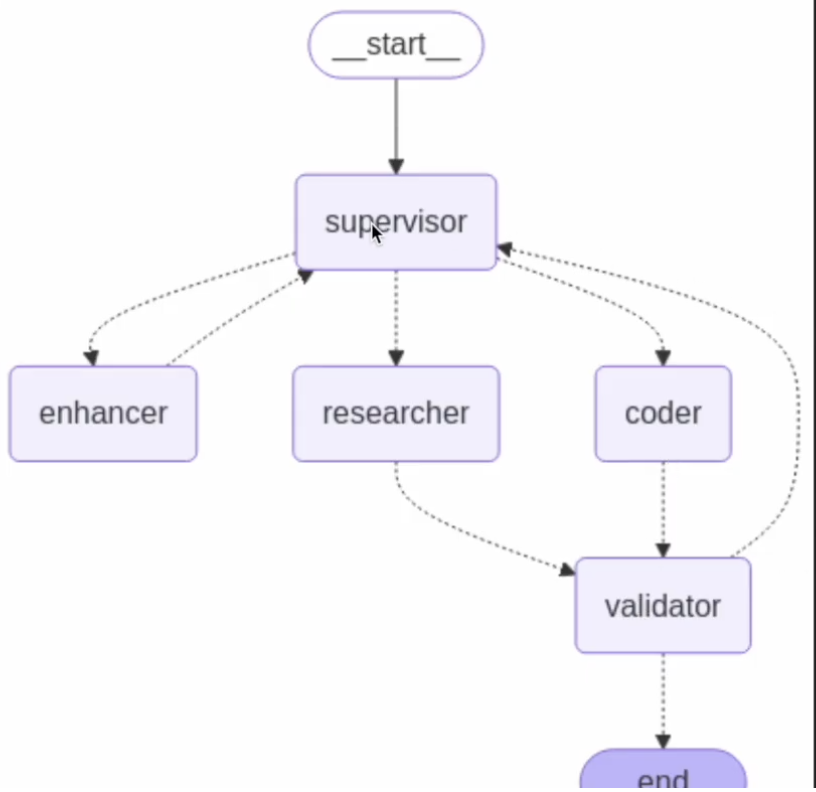

In [60]:
# %pip install langchain-experimental

In [61]:
from typing import List, Literal, Annotated, Sequence,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, add_messages,MessagesState
from langgraph.types import Command
from dotenv import load_dotenv
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
load_dotenv()

True

In [62]:
llm = ChatOpenAI(model="gpt-4o")

tavily_search = TavilySearchResults(max_results=2)

python_repl_tool = PythonREPLTool()

In [63]:
# llm.invoke(
# response = tavily_search.invoke("weather in chennai ?")

# print(response)

# final = "".join(result["content"] for result in response)

# x = llm.invoke("very concise : weather in chennai ?" + final)
# print(x)
# x.invoke("weather in chennai ?")

In [65]:
class Agent_state(TypedDict):
    messages : Annotated[List, add_messages]

In [66]:
class Supervisor_schema(BaseModel):
    next : Literal["enhancer","researcher","coder"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
        "'enhancer' when user input requires clarification, expansion, or refinement, "
        "'researcher' when additional facts, context, or data collection is necessary, "
        "'coder' when implementation, computation, or technical problem-solving is required."
    )

    reason : str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

In [67]:
def supervisor_node(state : MessagesState):
    system_prompt = ('''
                 
        You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher, and Coder. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
        2. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
        3. **Coder**: Focuses on technical implementation, calculations, data analysis, algorithm development, and coding solutions.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
    ''')


    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    response = llm.with_structured_output(Supervisor_schema).invoke(messages)

    next = response.next
    reason = response.reason
    print(f"Supervisor Decision: Next Agent - {next}, Reason - {reason}")

    return Command(
        update = {
            "messages":HumanMessage(content = reason, name = "Supervisor")
        },
        goto=next
    ) 


In [68]:
def enhancer_node(state: MessagesState):
    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
      
    system_prompt = (
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )

    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    response = llm.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update = {
            "messages": HumanMessage(content=response.content, name="Enhancer")
        },
        goto="supervisor"
    )

In [69]:
def research_node(state : MessagesState):
    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    system_prompt = (
        "You are a Research Specialist tasked with gathering relevant information to support the user's request. Your responsibilities include:\n\n"
        "1. Conducting thorough searches for factual data, context, and supporting information\n"
        "2. Summarizing findings in a clear, concise manner\n"
        "3. Ensuring all information is accurate and relevant to the task at hand\n\n"
        "Important: Focus on providing actionable insights without unnecessary details."
    )

    research_agent = create_react_agent(
        llm,  
        tools=[tavily_search],  
        # state_modifier= "You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
        #     "1. Identifying key information needs based on the query context\n"
        #     "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
        #     "3. Organizing findings in a structured, easily digestible format\n"
        #     "4. Citing sources when possible to establish credibility\n"
        #     "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
        #     "Provide thorough, factual responses without speculation where information is unavailable."
    )

    result = research_agent.invoke(state)


    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto="validator", 
    )

In [70]:
def code_node(state: MessagesState):
    """
        Coder agent node that implements solutions using Python REPL.
        Takes the current task state, executes code, and returns results.
    """
    
    code_agent = create_react_agent(
        llm,
        tools=[python_repl_tool]
        # state_modifier=(
        #     "You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions, "
        #     "and executing code. Handle technical problem-solving and data tasks."
        # )
    )

    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator",
    )

In [71]:
# System prompt providing clear instructions to the validator agent
system_prompt = '''
    Your task is to ensure reasonable quality. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
    - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
    - Accept answers that are "good enough" rather than perfect
    - Prioritize workflow completion over perfect responses
    - Give benefit of doubt to borderline answers
    
    Routing Guidelines:
    1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
    2. Respond with 'FINISH' in all other cases to end the workflow.
'''


class Validator_schema(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState):
    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator_schema).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END  
        print(" --- Transitioning to END ---")  
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

In [72]:
graph = StateGraph(Agent_state)
graph.add_node("supervisor", supervisor_node)
graph.add_node("enhancer", enhancer_node)  
graph.add_node("researcher", research_node) 
graph.add_node("coder", code_node) 
graph.add_node("validator", validator_node) 
graph.set_entry_point("supervisor")


app = graph.compile()

import pprint


inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

Supervisor Decision: Next Agent - coder, Reason - The user is requesting a specific Fibonacci number, which is a task that requires computation. The Coder is the most appropriate agent to calculate the 20th Fibonacci number as it involves implementing a sequence or using an algorithm to arrive at the correct result.
"Output from node 'supervisor':"
{ 'messages': HumanMessage(content='The user is requesting a specific Fibonacci number, which is a task that requires computation. The Coder is the most appropriate agent to calculate the 20th Fibonacci number as it involves implementing a sequence or using an algorithm to arrive at the correct result.', additional_kwargs={}, response_metadata={}, name='Supervisor', id='d6d2fc2f-b3e3-4907-8839-ac7416cc5039')}



Python REPL can execute arbitrary code. Use with caution.


--- Workflow Transition: Coder → Validator ---
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='coder', id='f0d5ed0d-e4bc-4350-9012-253f9dbc1bc3')]}

 --- Transitioning to END ---
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content="The answer correctly provides the 20th Fibonacci number as 6765, which is accurate and fully addresses the user's question. There is no misunderstanding or error in the response.", additional_kwargs={}, response_metadata={}, name='validator', id='6f10636c-a8b0-416c-a022-4a9b848741c3')]}

